In [11]:
import sys
sys.path.append('D:/UNESP/EngMec-UNESP/')
import frankenstein as fk

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import ZebraLib as zb
import uncertainties.unumpy as un

df = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu II/Lab 3 - Perda de carga/dados3.xlsx', 
                    sheet_name='df_data')

In [12]:
df_perda = fk.perda_carga(df[['TL', 'TR']])
df_Re = fk.df_calc_vazão(df[['PO_TL', 'PO_TR']], prop=3)

df1 = pd.concat([df_perda, df_Re], axis=1)
df1

,TL,TR,PO_TL,PO_TR
0,154.859025,220.062825,25523.334698,15486.641493
1,163.009500,122.257125,24728.720997,16127.362685
2,154.859025,187.460925,25523.334698,15155.737589
3,146.708550,195.611400,25523.334698,15155.737589
4,293.417100,586.834200,36965.097299,25718.054498
5,285.266625,578.683725,36425.664501,25718.054498
6,277.116150,562.382775,36015.682328,24525.938134
7,277.116150,546.081825,35461.518046,25129.250698
8,350.470425,725.392275,41973.331946,28475.830206
9,358.620900,733.542750,41500.197556,28475.830206


### 1 - Perda de carga e número de Re

In [21]:
def df_incert_grupo(df):
    it = [[0, 4], [4, 8], [8, 12], [12, 16]]
    nominal_values, std_devs = [], []
    for i in it:
        values = df[i[0]:i[1]].values
        nominal_values.append(values.mean())
        std_devs.append(values.std(ddof=1)/np.sqrt(len(values)))
    return un.uarray(nominal_values, std_devs) 


res1 = np.zeros((4, 4))
aux = []
for i in range(len(df1.columns)):
    nome_col = df1.columns[i]
    aux.append(df_incert_grupo(df1[nome_col]))

pd.DataFrame(np.array(aux).T , columns=['perda_TL', 'perda_TR', 'TL_Re', 'TR_Re'])  
#index são as vazões
#TL, TR -> perda de carga
#PO_TL, PO_TR -> Re

,perda_TL,perda_TR,TL_Re,TR_Re
0,154.9+/-3.3,181+/-21,(2.532+/-0.020)e+04,(1.548+/-0.023)e+04
1,283+/-4,568+/-9,(3.622+/-0.032)e+04,(2.527+/-0.029)e+04
2,354.5+/-2.4,725.4+/-3.3,(4.162+/-0.012)e+04,(2.834+/-0.008)e+04
3,370.8+/-2.4,792.6+/-2.0,43219+/-29,(2.959+/-0.008)e+04


### 2 - Rugosidade

In [ ]:
def calc_f(perda_carga, Vm):
    D1=0.0385 #m
    L = 5     #m
    return (2*D1*perda_carga)/(L*Vm**2)



In [4]:
it = [[0, 4], [4, 8], [8, 12], [12, 16]]

nominal_values, std_devs = [], []
for i in it:
    data = df[['TR']][i[0]:i[1]]
    perda = fk.perda_carga(data).values
    nominal_values.append(perda.mean())
    std_devs.append(perda.std(ddof=1)/np.sqrt(len(perda)))

perda_values = un.uarray(nominal_values, std_devs)

TypeError: df_calc_vazão() got an unexpected keyword argument 'min'

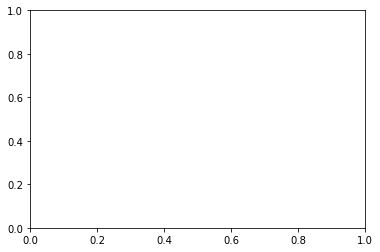

In [5]:
#%matplotlib
fig, ax = plt.subplots()
labels = ['3 Voltas', '5 voltas', '7 voltas', 'Aberta']
it = [[0, 4], [4, 8], [8, 12], [12, 16]]
for i in range(len(it)):
    par = it[i]

    y = fk.perda_carga(df['TL'][par[0]:par[1]].values)
    x = fk.df_calc_vazão(df[['PO_TL']], min=par[0], max=par[1])

    ax.scatter(x, y, label=f'{labels[i]}')

ax.legend()
ax.grid(ls='dotted')